In [2]:
# imports

import numpy as np
import matplotlib.pyplot as plt
import control

## EX 1:  Mass-spring damper system


Let us consider a mass-spring-damper system![TP1_SDSystem.png](attachment:TP1_SDSystem.png)

With the following system parameters:

      mass  m = 1.0 kg

      spring constant k = 5.0 N/m

      damping constant $\rho$ = 2 Ns/m

The state space model of the system is the following:

$$\dot x = Ax + Bu$$
$$ y = Cx$$

where
state vector $x = (p,v)$ (p - position, v - velocity), and state and control matrices are the following:
$$ A = \begin{pmatrix} 0&1\\ -\frac{k}{m}&-\frac{\rho}{m}\end{pmatrix},\ B = \begin{pmatrix} 0\\ \frac{1}{m} 
\end{pmatrix}$$

## TODO
1. Is the system controllable?
2. Design a PID controller that ensures that the position of the closed-loop system tracks the constant reference $y_{ref}(t) = 1.$ Plot the trajectory of the closed-loop system, starting from $x = (0,0).$ Tune PID to ensure that rising time < 10s, overshoot < 10%, Steady-state error < 2%.  
3. Design a full-state feedback controller with an integral term $u = -Kx + k_z\int_0^t(y_{ref}(\tau) - p(\tau))\,d\tau$ that ensures that the position of the closed-loop system tracks the constant reference $y_{ref}(t) = 1.$  Plot the trajectory of the closed-loop system, starting from $x = (0,0).$ Chose eigenvalues properly, to ensure that rising time < 10s, overshoot < 10%, Steady-state error < 2%.  
4. Compare the performance of PID and full-state feedback controllers. What can you say? 

Let us now work with a discretized version of the system.

5. Disretise the system with sampling time T = 0.1s
6. Design a discrete version of the PID controller that ensures that the position of the closed-loop system tracks the constant reference $y_{ref,k} = 1.$ Plot the trajectory of the closed-loop system, starting from $x = (0,0).$ Tune PID to ensure that rising time < 10s, overshoot < 10%, Steady-state error < 2%.  
7. Design a full-state feedback controller with an integral term $u_k = - Kx_k + k_z\sum_{i=0}^k(y_{ref, i} - p_i)$ that ensures that the position of the closed-loop system tracks the constant reference $y_{ref,k} = 1.$  Plot the trajectory of the closed-loop system, starting from $x = (0,0).$ Chose eigenvalues properly to ensure that rising time < 10s, overshoot < 10%, Steady-state error < 2%.  
8. Compare the performance of PID and full-state feedback controllers. What can you say?


In [3]:
# constants
rho = 2
k = 5
m = 1

### Question 1

In [4]:
A = np.array([[0, 1], [-k/m, -rho/m]])
B = np.array([[0], [1/m]])
C = np.array([[1, 0]])

# Controllability matrix
Cm = control.ctrb(A, B)
print("System is controllable" if np.linalg.matrix_rank(Cm) == A.shape[0] else "System is not controllable")

System is controllable


### Question 2

/home/joseph/.local/lib/python3.10/site-packages/scipy/signal/_lti_conversion.py:74: BadCoefficients: Badly conditioned filter coefficients (numerator): the results may be meaningless
  num, den = normalize(num, den)   # Strips zeros, checks arrays


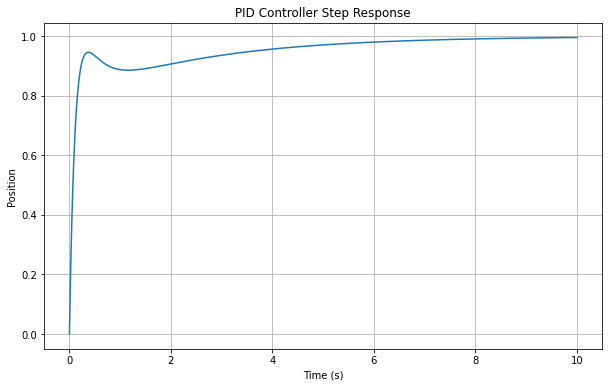

In [5]:
Kp = 25  # Proportional gain
Ki = 10   # Integral gain
Kd = 10   # Derivative gain

# State Space Representation
sys = control.ss(A, B, np.array([1, 0]), 0)
tf_sys = control.tf(sys)

# PID controller
pid = control.tf([Kd, Kp, Ki], [1, 0])

# Closed-loop system
cl_sys = control.feedback(tf_sys * pid, 1)

# Simulate response
t, y = control.step_response(cl_sys, T=10)

plt.figure(figsize=(10, 6))
plt.plot(t, y)
plt.title('PID Controller Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.grid(True)
plt.show()

The tuned PID matches the criterions.

### Question 3

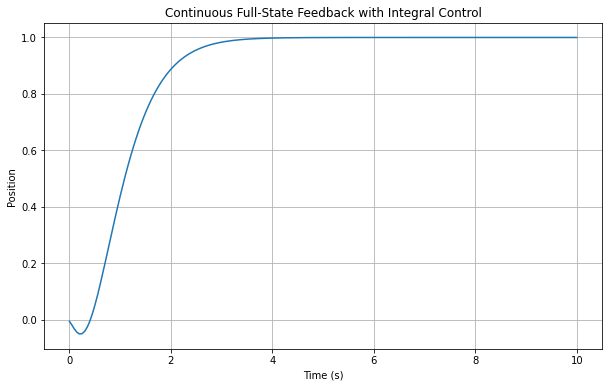

In [6]:
Aa = np.block([
    [A, np.zeros((2,1))],
    [-np.array([1, 0]), 0]
])
Ba = np.block([[B], [0]])

# Place poles for desired response
desired_poles = [-2, -3, -4]
K = control.place(Aa, Ba, desired_poles)

Na = np.linalg.pinv(np.block([Aa, Ba]))[:, -1]
N = Na[-1]  # Feedforward gain

def closed_loop_sim(t):
    # Initial conditions
    x = np.zeros(3)
    y_hist = []

    # Reference is constant 1
    y_ref = 1.0

    # Simulation step
    for i in range(len(t)):
        # Compute control input with integral action
        u = -K @ x + N * y_ref

        # Update state (using RK4 integration)
        def dynamics(x, u):
            x_dot = np.zeros(3)
            x_dot[:2] = Aa[:2, :2] @ x[:2] + Aa[:2, 2] * x[2] + B.flatten() * u
            x_dot[2] = y_ref - x[0]  # Integral of error
            return x_dot

        # RK4 integration
        k1 = dynamics(x, u)
        k2 = dynamics(x + 0.5 * t[1] * k1, u)
        k3 = dynamics(x + 0.5 * t[1] * k2, u)
        k4 = dynamics(x + t[1] * k3, u)

        x += (t[1] / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

        y_hist.append(x[0])

    return y_hist

# Generate time vector
t = np.linspace(0, 10, 200)

# Simulate and plot
y = closed_loop_sim(t)

plt.figure(figsize=(10, 6))
plt.plot(t, y)
plt.title('Continuous Full-State Feedback with Integral Control')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.grid(True)
plt.show()

### Question 4

We see that the Full-State Feedback with integral control is much more performant : it is as fast as the PID, it does not overshoot nor oscillates and is perfectly precise, whereas the PID controller takes more time to converge towards the final value.

### Question 5

In [7]:
T = 0.1  # Sampling time

# Discretize system
Ad = np.eye(2) + A * T
Bd = B * T

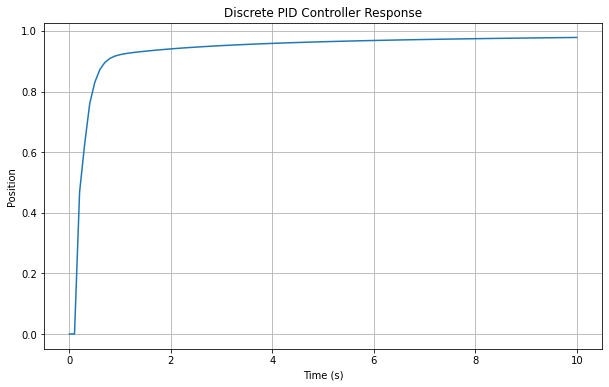

In [8]:
# Similar PID design principles as continuous case
Kp_d = 30
Ki_d = 1.8
Kd_d = 15

# Simulate discrete system response
x = np.zeros(2)
y_ref = 1.0
y_hist = [x[0]]
t_hist = [0]

for k in range(100):
    # PID control law
    u = Kp_d * (y_ref - x[0]) + Ki_d * sum(y_ref - x[0] for _ in range(k+1)) + Kd_d * (y_ref - x[0] - x[1])

    # Update state
    x_next = Ad @ x + Bd * u

    y_hist.append(x_next[0][0])
    t_hist.append((k+1)*0.1)
    x = x_next

    
plt.figure(figsize=(10, 6))
plt.plot(t_hist, y_hist)
plt.title('Discrete PID Controller Response')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.grid(True)
plt.show()

### Question 7

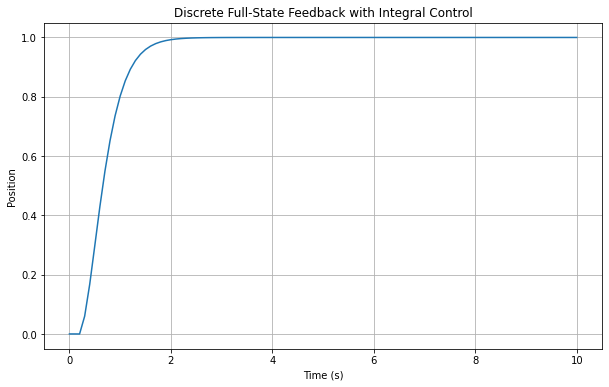

In [9]:
T = 0.1  # Sampling time
Ad = np.eye(2) + A * T
Bd = B * T

# Augmented discrete system
Aa_d = np.block([
    [Ad, np.zeros((2,1))],
    [-np.array([1, 0]), 1]
])
Ba_d = np.block([[Bd], [0]])

# Choose discrete poles
desired_poles_d = [0.5, 0.6, 0.7]
K_d = control.place(Aa_d, Ba_d, desired_poles_d)

# Compute feedforward gain
Na_d = np.linalg.pinv(np.block([Aa_d, Ba_d]))[:, -1]
N_d = Na_d[-1]

# Simulation
def discrete_closed_loop_sim():
    # Initial conditions
    x = np.zeros(3)
    y_ref = 1.0

    # Storage for results
    y_hist = [x[0]]
    t_hist = [0]

    # Simulate for 100 steps
    for k in range(100):
        # Compute control input with integral action
        u = -K_d @ x + N_d * y_ref

        # Update augmented state
        x_next = np.zeros(3)
        x_next[:2] = Aa_d[:2, :2] @ x[:2] + Aa_d[:2, 2] * x[2] + Ba_d[:2].flatten() * u
        x_next[2] = x[2] + (y_ref - x[0])  # Integral of error

        y_hist.append(x_next[0])
        t_hist.append((k+1)*T)
        x = x_next

    return t_hist, y_hist

# Simulate and plot
t, y = discrete_closed_loop_sim()

plt.figure(figsize=(10, 6))
plt.plot(t, y)
plt.title('Discrete Full-State Feedback with Integral Control')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.grid(True)
plt.show()

### Question 8

We have exactly the same observations as the previous questions : the discrete full-state feedback is better than the PID. Also, I noticed that the PID is way more unstable during tuning when using discrete time, mainly due to the integral term.

## Ex 2. Quadruple-Tank Process

![rsz_2024-01-30_22-36-17.png](attachment:rsz_2024-01-30_22-36-17.png)

Let us consider the Quadruple-Tank Process. A schematic diagram of the process is shown in the Figure above. The
target is to control the level in the lower two tanks with two pumps. The process inputs are $v_1$ and $v_2$ (input voltages to the pumps) and the outputs are $y_1$ and $y_2$ (voltages from level measurement devices). Mass balances and Bernoulli’s law yield

$$
\dfrac{dh_1}{dt} = -\dfrac{a_1}{A_1}\sqrt{2gh_1} + \dfrac{a_3}{A_1}\sqrt{2gh_3} + \dfrac{\gamma_1k_1}{A_1}v_1 = f_1(h_1,h_2,h_3,h_4,v_1,v_2)
$$

$$
\dfrac{dh_2}{dt} = -\dfrac{a_2}{A_2}\sqrt{2gh_2} + \dfrac{a_4}{A_2}\sqrt{2gh_4} + \dfrac{\gamma_2k_2}{A_2}v_2 = f_2(h_1,h_2,h_3,h_4,v_1,v_2)
$$

$$
\dfrac{dh_3}{dt} = -\dfrac{a_3}{A_3}\sqrt{2gh_3} + \dfrac{(1-\gamma_2)k_2}{A_3}v_2 = f_3(h_1,h_2,h_3,h_4,v_1,v_2)
$$

$$
\dfrac{dh_4}{dt} = -\dfrac{a_4}{A_4}\sqrt{2gh_4} + \dfrac{(1-\gamma_1)k_1}{A_4}v_1 = f_4(h_1,h_2,h_3,h_4,v_1,v_2)
$$

where

$A_i$ is a cross-section of Tank i

$a_i$ is a cross-section of outlet hole of Tank i

$h_i$ is a water level.

The voltage applied to Pump $i$ is $v_i$ and the corresponding flow
is $k_iv_i$. The parameters $\gamma_1,\gamma_2\in (0,1)$ are determined from how the valves are set prior to experiment. The flow to Tank 1
is $\gamma_1k_1v_1$ and the flow to Tank 4 is $(1-\gamma_1)k_1v_1$ and similarly
for Tank 2 and Tank 3. The acceleration of gravity is denoted $g$.
The measured level signals are $k_c h_1$ and $k_c h_2$. The parameter
values of the laboratory process are given in the following table

    A_1, A_3 [cm^2] 28
    A_2, A_4 [cm^2] 32
    a_1, a_3 [cm^2] 0.071
    a_2, a_4 [cm^2] 0.057
    k_c [V/cm] 0.50
    g [cm/s^2] 9.81
    k_1 [cm^3/Vs] 3.33
    k_2 [cm^3/Vs] 3.35
    gamma_1 0.70
    gamma_2 0.60
    
Check the following paper for more details on the model. 
https://www.diva-portal.org/smash/get/diva2:495784/FULLTEXT01.pdf

## TODO
1. Linearise the system around the operating point 
$$(h_1^0,h_2^0,h_3^0,h_4^0, v_1^0, v_2^0) = (12.4,12.7,1.8,1.4,3.00,3.00).$$
Pass to shifted variables $x_i = h_i-h_i^0, u_i = v_i - v_i^0.$

2. Is the linear system controllable? Is the linear system observable? Use the Kalman rank test to answer this question.

3. Imagine that one of the pumps is broken and there is no flow through it. Does the system remain controllable?

4. Let us measure the signals $x_3, x_4$ instead of measuring the signals $x_1$ and $x_2,$ I .e matrix
   $$C= \begin{pmatrix} 0&0&1&0\\ 0&0&0&1 \end{pmatrix}$$
   instead of
   $$C= \begin{pmatrix} 1&0&0&0\\ 0&1&0&0 \end{pmatrix}.$$
 Is such a system observable?

### Question 1 : Linearize the system
Let's linearize the system around the given operating point, using the shifted variables $x_i = h_i -h_i^0$ and $u_i = v_i - v_i^0$.

We get :
$$
\large
\frac{dx}{dt} = \begin{bmatrix} 
-\frac{1}{T_1} & 0 & \frac{A_3}{A_1 T_3} & 0 \\
0 & -\frac{1}{T_2} & 0 & \frac{A_4}{A_2 T_4} \\
0 & 0 & \frac{-1}{T_3} & 0 \\
0 & 0 & 0 & \frac{-1}{T_4} \end{bmatrix} x + 
\begin{bmatrix} 
\frac{\gamma_1 k_1}{A_1} & 0 \\
0 & \frac{\gamma_2 k_2}{A_2} \\
0 & \frac{(1-\gamma_2) k_2}{A_3} \\
\frac{(1-\gamma_1) k_1}{A_4} & 0 \end{bmatrix} u 
$$

$\large T_i = \frac{A_i}{a_i}\sqrt{\frac{2h_i^0}{g}}$, $i=1,..,4$

### Question 2 : Is the system controllable and observable  ? 

We have $A = \begin{bmatrix} 
-\frac{1}{T_1} & 0 & \frac{A_3}{A_1 T_3} & 0 \\
0 & -\frac{1}{T_2} & 0 & \frac{A_4}{A_2 T_4} \\
0 & 0 & \frac{-1}{T_3} & 0 \\
0 & 0 & 0 & \frac{-1}{T_4} \end{bmatrix}$, $B = \begin{bmatrix} 
\frac{\gamma_1 k_1}{A_1} & 0 \\
0 & \frac{\gamma_2 k_2}{A_2} \\
0 & \frac{(1-\gamma_2) k_2}{A_3} \\
\frac{(1-\gamma_1) k_1}{A_4} & 0 \end{bmatrix}$,  $C = \begin{bmatrix} k_c &0&0&0 \\ 0& k_c &0&0 \end{bmatrix}$ and $ D = \begin{bmatrix}0&0\\0&0\end{bmatrix} $

Let's use the python control library to find out if the system is controllable.

In [10]:
import control
import numpy as np

# Let's input all the parameters :

A_1, A_3 = 28, 28
A_2, A_4 = 32, 32
a_1, a_3 = 0.071, 0.071
a_2, a_4 = 0.057, 0.057
k_c = 0.50
g = 9.81
k_1 = 3.33
k_2 = 3.35
gamma_1 = 0.70
gamma_2 = 0.60

h01 = 12.4
h02 = 12.7
h03 = 1.8
h04 = 1.4
v01 = 3.00
v02 = 3.00

T1 = np.sqrt((2*h01)/g)*A_1/a_1
T2 = np.sqrt((2*h02)/g)*A_2/a_2
T3 = np.sqrt((2*h03)/g)*A_3/a_3
T4 = np.sqrt((2*h04)/g)*A_4/a_4

A = np.array([[-1/T1, 0, A_3/(A_1*T3), 0], [0, -1/T2, 0, A_4/(A_2*T4)], [0, 0, -1/T3, 0], [0, 0, 0, -1/T4]])
B = np.array([[gamma_1*k_1/A_1, 0], [0, gamma_2*k_2/A_2], [0, (1-gamma_2)*k_2/A_3], [(1-gamma_1)*k_1/A_4, 0]])
C = np.array([[k_c, 0, 0, 0], [0, k_c, 0, 0]])
D = np.zeros((2,2))

In [11]:
system = control.ss(A, B, C, D)

ctrb_m = control.ctrb(system.A, system.B)
obsv_m = control.obsv(system.A, system.C)
C_rank = np.linalg.matrix_rank(ctrb_m)
O_rank = np.linalg.matrix_rank(obsv_m)

print("Controllability matrix rank :", C_rank)
print("Observability matrix rank :", O_rank)

Controllability matrix rank : 4
Observability matrix rank : 4


We see that both ranks are equal to 4. As n is also equal to 4, thus the system is both controllable and observable.

### Question 3 : Does the system remain controllable with one of the two pumps broken ?

First, let's suppose that pump number 1 is broken. We then have $B = \begin{bmatrix} 
0 & 0 \\
0 & \frac{\gamma_2 k_2}{A_2} \\
0 & \frac{(1-\gamma_2) k_2}{A_3} \\
0 & 0 \end{bmatrix} $. 
Let's run the python code again to see the results.

In [12]:
B2 = np.array([[0, 0], [0, gamma_2*k_2/A_2], [0, (1-gamma_2)*k_2/A_3], [0, 0]])
print(B2)

[[0.         0.        ]
 [0.         0.0628125 ]
 [0.         0.04785714]
 [0.         0.        ]]


In [13]:
B2 = np.array([[0, 0], [0, gamma_2*k_2/A_2], [0, (1-gamma_2)*k_2/A_3], [0, 0]])
print(B2)

system_2 = control.ss(A, B2, C, D)

ctrb_m = control.ctrb(system_2.A, system_2.B)
obsv_m = control.obsv(system_2.A, system_2.C)
C_rank = np.linalg.matrix_rank(ctrb_m)
O_rank = np.linalg.matrix_rank(obsv_m)

print("Controllability matrix rank :", C_rank)

[[0.         0.        ]
 [0.         0.0628125 ]
 [0.         0.04785714]
 [0.         0.        ]]
Controllability matrix rank : 3


We see that the rank of the controllability matrix drops to 3. Let's try for the other pump :

In [14]:
B3 = np.array([[gamma_1*k_1/A_1, 0], [0, 0], [0, 0], [(1-gamma_1)*k_1/A_4, 0]])
print(B3)

system_3 = control.ss(A, B3, C, D)

ctrb_m = control.ctrb(system_3.A, system_3.B)
obsv_m = control.obsv(system_3.A, system_3.C)
C_rank = np.linalg.matrix_rank(ctrb_m)
O_rank = np.linalg.matrix_rank(obsv_m)

print("Controllability matrix rank :", C_rank)

[[0.08325    0.        ]
 [0.         0.        ]
 [0.         0.        ]
 [0.03121875 0.        ]]
Controllability matrix rank : 3


We get the result we expected.

Thus, the system is no longer controllable with one of the two pumps broken, which is logical.

### Question 4 : changing the measured signals to $x_3$ and $x_4$, does the system remain observable? 

The only difference with the question 2 is the matrix C, which becomes $C = \begin{bmatrix}0&0& k_c &0\\0&0&0& k_c\end{bmatrix}$

In [15]:
C2 = np.array([[0, 0, k_c, 0], [0, 0, 0, k_c]])

system_4 = control.ss(A, B, C2, D)

ctrb_m = control.ctrb(system_4.A, system_4.B)
obsv_m = control.obsv(system_4.A, system_4.C)
C_rank = np.linalg.matrix_rank(ctrb_m)
O_rank = np.linalg.matrix_rank(obsv_m)

print("Observability matrix rank :", O_rank)

Observability matrix rank : 2


The system isn't observable anymore.

## EX3: Inverted Pendulum

![2024-01-23_13-32-20.png](attachment:2024-01-23_13-32-20.png)
The system in this example consists of an inverted pendulum mounted to a motorized cart. The inverted pendulum system is an example commonly found in control system textbooks and research literature. Its popularity derives in part from the fact that it is unstable without control, that is, the pendulum will simply fall over if the cart isn't moved to balance it. Additionally, the dynamics of the system are nonlinear. The objective of the control system is to balance the inverted pendulum by applying a force to the cart that the pendulum is attached to. A real-world example that relates directly to this inverted pendulum system is the attitude control of a booster rocket at takeoff.
The system in this example consists of an inverted pendulum mounted to a motorized cart. The inverted pendulum system is an example commonly found in control system textbooks and research literature. Its popularity derives in part from the fact that it is unstable without control, that is, the pendulum will simply fall over if the cart isn't moved to balance it. Additionally, the dynamics of the system are nonlinear. The objective of the control system is to balance the inverted pendulum by applying a force to the cart that the pendulum is attached to. A real-world example that relates directly to this inverted pendulum system is the attitude control of a booster rocket at takeoff.


Let us consider the system with the following system parameters

    (M)       mass of the cart                         0.5 kg
    
    (m)       mass of the pendulum                     0.2 kg
    
    (l)       length to pendulum center of mass        0.3 m
    
    (b)       coefficient of friction for cart         0.1 N/m/sec
    
    (I)       mass moment of inertia of the pendulum   0.006 kg.m^2
    
    (F)       force applied to the cart
    
    (y)       cart position coordinate
    
    (theta)   angle between the pendulum and the vertical axis

## TODO

1) Show that the inverted pendulum on the cart can be modeled as follows

$$(M+m)\ddot{y} + b\dot{y} + ml\ddot{\theta}\cos\theta -ml\dot\theta^2\sin(\theta) = F$$

$$ml\cos(\theta)\ddot{y} + (I+ml^2)\ddot{\theta} - mgl\sin\theta = 0$$    

2) Let the state vector $x = (y,y_1,\theta,\theta_1),$ where $y_1 = \dot{y}$ and $\theta_1 = \dot{\theta}.$ Lineralize the system around equlibrium  point $x = (0,0,0,0).$

3) Is the autonomous system stable (u = 0)? Is the system controllable? Design a full state feedback controller $u = -Kx$ assigning the following eigenvalues $\lambda_1 = - 1, \lambda_2 = -2, \lambda_3 = -1.5, \lambda_4 = -2.5$ in the closed-loop system. Is a closed-loop system stable?

4) Let us assume that we only measure the position $y$ and the angular velocitity $\theta$. What is the right matrix C? Is the system observable?

5) Design an optimal estimator (LQE) and optimal estimated state feedback controller (LQR) which stabilize the system in (0,0,0,0).

6) Use the following library to implement an MPC controller
    https://github.com/forgi86/pyMPC/blob/master/README.md
   that stabilize the system while ensuring that following state and input constraints are satisfied

   $x_{min} = [-5,-100,-100,-100]\leq x \leq x_{max}= [5,100,100,100]$
   
   $u_{min} = -20 \leq u\leq u_{max}=20$
   
   The following notebook can be useful for you 
   https://github.com/forgi86/pyMPC/blob/master/examples/example_inverted_pendulum.ipynb
   

In [17]:
# System Parameters
M = 0.5    # mass of cart (kg)
m = 0.2    # mass of pendulum (kg)
l = 0.3    # length to pendulum center of mass (m)
b = 0.1    # coefficient of friction for cart (N/m/sec)
I = 0.006  # mass moment of inertia of pendulum (kg.m^2)
g = 9.81   # gravitational acceleration (m/s^2)

### Question 2

The system is governed by the following differential equations:

\begin{equation}
 \begin{aligned}
 (M+m)\ddot p + ml\ddot\phi \cos\phi - ml \dot \phi ^2 \sin \phi + b\dot p &= F \\
 l \ddot \phi + \ddot p \cos \phi - g \sin\phi &= -f_\phi\dot \phi
\end{aligned}
\end{equation}

Introducing the state vector $x=[p\; \dot p\; \phi\; \dot \phi]$ and the input $u=F$, the system dynamics are described in state-space by a set of an nonlinear ordinary differential equations: $\dot x = f(x,u)$ with

\begin{equation}
\begin{split}
  f(x,u) &= 
 \begin{bmatrix}
 x_2\\
 \frac{-mg \sin x_3\cos x_3 + mlx_4^3\sin x_3 + f_\phi m x_4 \cos x_3 - bx_2 + u }{M+(1-\cos^2 x_3)m}\\
 x_3\\
 \frac{(M+m)(g \sin x_3 - f_\phi x_4) - (lm x_4^2 \sin x_3 - bx_2 + u)\cos x_3}{l(M+(1-\cos^2 x_3)m)}
 \end{bmatrix}\\ 
 \end{split}
 \end{equation}

For MPC control design, the system is linearized about the upright (unstable) equilibrium point, i.e., about the point $x_{eq} = [0, \; 0\;, 0,\; 0]^\top$.
The linearized system has form $\dot  x =  A_c x + B_c u$ with

\begin{equation}
  A = 
 \begin{bmatrix}
 0& 1& 0& 0\\
 0& -\frac{b}{M}& -g\frac{m}{M}& f_\theta\frac{m}{M}\\
 0&0&0&1\\
 0&\frac{b}{Ml}& \frac{g(M+m)}{Ml}&-\frac{(M+m)f_\theta}{M l}
 \end{bmatrix},\qquad B= 
 \begin{bmatrix}
 0\\
 \frac{1}{M}\\
 0\\
 -\frac{1}{Ml}&
 \end{bmatrix}
 \end{equation}

In [25]:
# Linearized A matrix
A = np.array([
    [0, 1, 0, 0],
    [0, -b/M, -m*g/M, 0],
    [0, 0, 0, 1],
    [0, b/(M*l), g*(M+m)/(l*M), 0]
])

# Linearized B matrix 
B = np.array([
    [0],
    [1/M],
    [0],
    [1/(M*l)]
])

print(A)
print(B)

[[ 0.          1.          0.          0.        ]
 [ 0.         -0.2        -3.924       0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.66666667 45.78        0.        ]]
[[0.        ]
 [2.        ]
 [0.        ]
 [6.66666667]]


### Question 3

In [27]:
# Check controllability
Co = control.ctrb(A, B)
print("Controllability Matrix Rank:", np.linalg.matrix_rank(Co))

# Desired eigenvalues
poles = [-1, -2, -1.5, -2.5]

# Design feedback gain
K = control.place(A, B, poles)

Controllability Matrix Rank: 4


Thus, the system is controllable.

### Question 4

In [31]:
C = np.array([
    [1, 0, 0, 0],  # cart position
    [0, 0, 1, 0]   # pendulum angle
])

# Check observability
Ob = control.obsv(A, C)
print("Observability Matrix Rank:", np.linalg.matrix_rank(Ob))

Observability Matrix Rank: 4


Thus, the system is observable

### Question 5

In [35]:
# Q matrix (state penalty for LQR)
Q = np.eye(4)

# R matrix (control input penalty for LQR)
R = np.array([[1]])

# LQR design
K_lqr, _, _ = control.lqr(A, B, Q, R)

Q_noise = np.eye(B.shape[1]) * 0.01  # Small process noise

# Measurement noise covariance matrix (R)
R_noise = np.eye(2) * 0.1   # Measurement noise

# LQE (Kalman Filter) design
L = control.lqe(A, B, C, Q_noise, R_noise)

### Question 6

In [45]:
!pip install python-mpc

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.6/340.6 KB 2.1 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.8/301.8 KB 7.5 MB/s eta 0:00:000:00:01


/tmp/ipykernel_6262/3289000715.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  der[1] = (m * l * np.sin(theta) * omega ** 2 - m * g * np.sin(theta) * np.cos(theta) + m * ftheta * np.cos(theta) * omega + F - b * v) / (M + m * (1 - np.cos(theta) ** 2))
/tmp/ipykernel_6262/3289000715.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  der[3] = ((M + m) * (g * np.sin(theta) - ftheta * omega) - m * l * omega ** 2 * np.sin(theta) * np.cos(theta) - (F - b * v) * np.cos(theta)) / (l * (M + m * (1 - np.cos(theta) ** 2)))


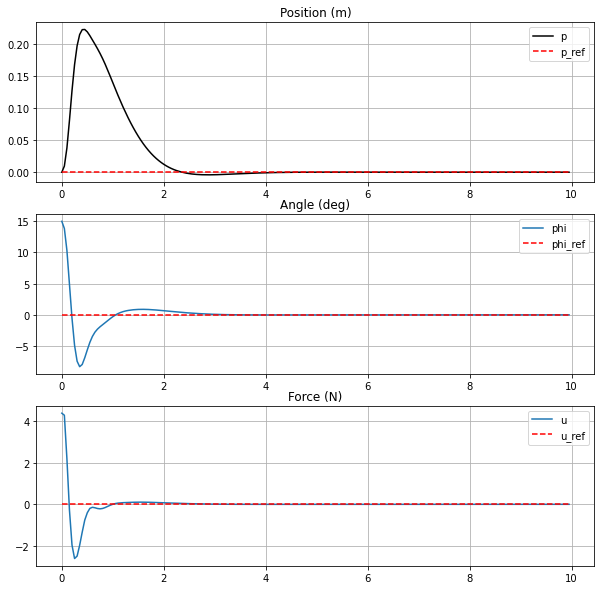

In [49]:
import scipy.sparse as sparse
from scipy.integrate import ode
import time
from pyMPC.mpc import MPCController

Ts = 50e-3
ftheta = 0.1

def f_ODE(t,x,u):
    F = u
    v = x[1]
    theta = x[2]
    omega = x[3]
    der = np.zeros(4)
    der[0] = v
    der[1] = (m * l * np.sin(theta) * omega ** 2 - m * g * np.sin(theta) * np.cos(theta) + m * ftheta * np.cos(theta) * omega + F - b * v) / (M + m * (1 - np.cos(theta) ** 2))
    der[2] = omega
    der[3] = ((M + m) * (g * np.sin(theta) - ftheta * omega) - m * l * omega ** 2 * np.sin(theta) * np.cos(theta) - (F - b * v) * np.cos(theta)) / (l * (M + m * (1 - np.cos(theta) ** 2)))
    return der

# Continuous-time system matrices, linearized about the upright, unstable equilibrium point 
Ac =np.array([[0,       1,          0,                  0],
              [0,       -b/M,       -(g*m)/M,           (ftheta*m)/M],
              [0,       0,          0,                  1],
              [0,       b/(M*l),    (M*g + g*m)/(M*l),  -(M*ftheta + ftheta*m)/(M*l)]])

Bc = np.array([
    [0.0],
    [1.0/M],
    [0.0],
    [-1/(M*l)]
])


[nx, nu] = Bc.shape # number of states and number or inputs

# Simple forward euler discretization
Ad = np.eye(nx) + Ac*Ts
Bd = Bc*Ts

xref = np.array([0.0, 0.0, 0.0, 0.0]) # reference state
uref = np.array([0.0])    # reference input
uminus1 = np.array([0.0])     # input at time step negative one - used to penalize the first delta u at time instant 0. Could be the same as uref.

# Constraints
xmin = np.array([-100.0, -100, -100, -100])
xmax = np.array([100.0,   100.0, 100, 100])

umin = np.array([-20])
umax = np.array([20])

Dumin = np.array([-5])
Dumax = np.array([5])

# MPC cost function weights

Qx = sparse.diags([0.3, 0, 1.0, 0])   # Quadratic cost for states x0, x1, ..., x_N-1
QxN = sparse.diags([0.3, 0, 1.0, 0])  # Quadratic cost for xN
Qu = 0.0 * sparse.eye(1)        # Quadratic cost for u0, u1, ...., u_N-1
QDu = 0.01 * sparse.eye(1)       # Quadratic cost for Du0, Du1, ...., Du_N-1

# Initialize simulation system

phi0 = 15*2*np.pi/360
x0 = np.array([0, 0, phi0, 0]) # initial state
t0 = 0
system_dyn = ode(f_ODE).set_integrator('vode', method='bdf')
system_dyn.set_initial_value(x0, t0)
system_dyn.set_f_params(0.0)

Np = 40

# Initialize and setup MPC controller

K = MPCController(Ad,Bd,Np=Np, x0=x0,xref=xref,uminus1=uminus1,
                  Qx=Qx, QxN=QxN, Qu=Qu,QDu=QDu,
                  xmin=xmin,xmax=xmax,umin=umin,umax=umax,Dumin=Dumin,Dumax=Dumax)
K.setup() # this initializes the QP problem for the first step

# Simulate in closed loop. Use MPC model as real system

# Simulate in closed loop
[nx, nu] = Bd.shape # number of states and number or inputs
len_sim = 10 # simulation length (s)
nsim = int(len_sim/Ts) # simulation length(timesteps)
xsim = np.zeros((nsim,nx))
usim = np.zeros((nsim,nu))
tsim = np.arange(0,nsim)*Ts

time_start = time.time()

t_step = t0
uMPC = uminus1
for i in range(nsim):
    xsim[i,:] = system_dyn.y

    # MPC update and step. Could be in just one function call
    K.update(system_dyn.y, uMPC) # update with measurement
    uMPC = K.output() # MPC step (u_k value)
    usim[i,:] = uMPC

    # System simulation
    system_dyn.set_f_params(uMPC) # set current input value
    system_dyn.integrate(t_step + Ts)

    # Time update
    t_step += Ts
time_sim = time.time() - time_start

# Plot results

fig,axes = plt.subplots(3,1, figsize=(10,10))
axes[0].plot(tsim, xsim[:,0], "k", label='p')
axes[0].plot(tsim, xref[0]*np.ones(np.shape(tsim)), "r--", label="p_ref")
axes[0].set_title("Position (m)")

axes[1].plot(tsim, xsim[:,2]*360/2/np.pi, label="phi")
axes[1].plot(tsim, xref[2]*360/2/np.pi*np.ones(np.shape(tsim)), "r--", label="phi_ref")
axes[1].set_title("Angle (deg)")

axes[2].plot(tsim, usim[:,0], label="u")
axes[2].plot(tsim, uref*np.ones(np.shape(tsim)), "r--", label="u_ref")
axes[2].set_title("Force (N)")

for ax in axes:
    ax.grid(True)
    ax.legend()